In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [3]:
100278.59/Lv

0.040095397840863654

In [4]:
4.87*365

1777.55

In [5]:
#WATER

def manabe_rh(rhs, p):
#    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    rh = rhs*(p/p[0]-0.02)/(1-0.02)
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr_fixed_strato(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def rh_to_vmr(rh,T,p,itop):
    mixing_ratio = np.ones_like(T)
    vmr_itop = konrad.physics.relative_humidity2vmr(rh[itop],p[itop],T[itop])
    mixing_ratio[:itop] = konrad.physics.relative_humidity2vmr(rh[:itop],p[:itop],T[:itop])
    mixing_ratio[itop:] = vmr_itop
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

def column_water_mass(vmr,ph): #kg m-2
    mmr = vmr_to_mmr(vmr) #kg kg-1
    dp = np.diff(ph)
    M_water = np.sum(-dp*mmr/g)
    
    return M_water
    
def opt_column_water_to_rh(M_water,T_atm,p,ph,itop):
    
    def fun(rhs):
        rh = manabe_rh(rhs, p)
        vmr = rh_to_vmr(rh,T_atm,p,itop)
        rh_w_mass = column_water_mass(vmr,ph)
        res = rh_w_mass - M_water
        return res
    
    rhs_opt = optimize.brentq(fun, 0., 2)
    rh_opt = manabe_rh(rhs_opt, p)
    return rh_opt

In [6]:
#AIR

def convective_top(T_con,T_rad):
    itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][0]
    if itop == 0:
        itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][1]
    
    return itop

def coldpoint(T):
    itop = np.where(np.diff(atmosphere['T'][0])>=0)[0][0]
    
    return itop

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
#    T_moist_ad = np.append(T_bl,konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.))[:-1]
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)

    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [7]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    return energy #J m-2

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    return energy #J m-2

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad, T_surface, SH): #find T after convective adjustment conserving thermal energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    thermal_energy = TE(T_rad,p) + SH
    tol = 10

    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist - thermal_energy
        return res
    
    Tc = T_rad[0]
    Th = T_surface
    
    dpos = fun(Th)
    dneg = fun(Tc)
    
    if dneg > 0:
        print('Trad high already', dneg)
        ds = dneg
        dneg = 0
        Ts = Tc
    
    if dpos < 0:
        print('Tsurf low already', dpos)
        ds = dpos
        dpos = 0
        Ts = Th
        
    Ts = Tc + (Th-Tc) * -dneg/(-dneg+dpos)
    ds = fun(Ts)
#    print(ds)

    if ds > 0:
        dpos = ds
        Th = Ts
    else:
        dneg = ds
        Tc = Ts
    
    maxiter = 100
    k = 0
    while dpos>tol and np.abs(dneg)>tol and k < maxiter:
        Ts = Tc + (Th-Tc) * -dneg/(-dneg+dpos)
        ds = fun(Ts)
    #    print(ds)
        
        if ds > 0:
            dpos = ds
            Th = Ts
        else:
            dneg = ds
            Tc = Ts
        k += 1
        
    if k == 100:
        print(dpos, dneg, ds, Th, Tc, Ts, T_rad[0])
        print('reached max iter')
    T_bl = Ts
    T_con = moist_adiabat(p,T_bl,T_rad)

    return T_con, ds


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p) + SH
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [8]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

In [9]:
%%time
#### PRECIPITATION TEST
heat_sink = 0.
opacity = 66.

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    depth = 50)
radiation = konrad.radiation.RRTMG(solar_constant=551.58-opacity)
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev'])
print(M_w)

ndays = 15
timestep = 0.5 #days
nsteps = int(ndays/timestep)

Bowen = 0.1
prec_eff = 1/(1+Bowen)
print(prec_eff)

printcounter = 0
status = 0

Ts_rec = []
Tbl_rec = []
rads_rec = []
rada_rec = []
LH_rec = []
SH_rec = []
PH_rec = []
ctop_rec = []
RHs_rec = []
P_rec = []

for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    troposphere_radiation = np.sum(rad_heat_atm[:conv_top])
    atm_rad = np.sum(rad_heat_atm[:])
     
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:] = ((rad_heat_atm[:])
                                 /cp_air * g/-np.diff(atmosphere['phlev'])[:] * seconds_day)

    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    #temperature of atmosphere after radiative update

    atmosphere['T'] += heating_rates * timestep
    T_radiation = atmosphere['T'][0].copy()
    
#    print('pre rad',surface['temperature'])
        #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    old_T_bl = np.sum(T_radiation[:n_bl])/n_bl
    
    #    print('post rad',surface['temperature'])
    LH = latent_heat(vmr_bl, old_T_bl,atmosphere['phlev'][0])
    SH = sensible_heat(old_T_bl,surface['temperature'].copy(),atmosphere['phlev'][0])
#    print(SH,LH)
    
    prec_eff = np.minimum(1.,LH/(LH+SH))
#    print(prec_eff)
    

    status += 1
    Ts_rec.append(surface['temperature'].copy())
    Tbl_rec.append(old_T_bl)
    rads_rec.append(net_rad_surface)
    LH_rec.append(LH)
    SH_rec.append(SH)
    rada_rec.append(-troposphere_radiation)
    ctop_rec.append(conv_top)
#    Trad_rec.append(T_radiation)
    
    if printcounter == 200:
        print(status/2)
        printcounter = 0
    
    
    printcounter += 1
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    surface['temperature'] += ((- SH - LH - heat_sink/2) 
                               * seconds_day * timestep / surface.heat_capacity)
    
    prec_heating = prec_eff * troposphere_radiation #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv * seconds_day * timestep
    
    atmosphere['T'][0], E_dif = T_convection_TE(atmosphere['plev'], T_radiation, surface['temperature'],
                                         (SH - prec_heating - heat_sink/2) * seconds_day * timestep)

    prec_mass -= E_dif/Lv

    
    #water adjustment
    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    cold_point = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + prec_mass + LH/Lv *seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],cold_point)
    RHs_rec.append(RH[0])
    PH_rec.append(-prec_heating)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],cold_point)

18.767710263973953
0.9090909090909091
CPU times: user 2.24 s, sys: 9.56 ms, total: 2.25 s
Wall time: 2.24 s


In [22]:
RH_1 = RH.copy()
vmr_1 = atmosphere['H2O'][0].copy()
T_atm_1 = atmosphere['T'][0].copy()
SH_1 = SH.copy()
LH_1 = LH.copy()
Prec_1 = prec_mass.copy()/timestep
atm_rad_1 = atm_rad.copy()
sfc_rad_1 = net_rad_surface.copy()
T_sfc_1 = surface['temperature'].copy()

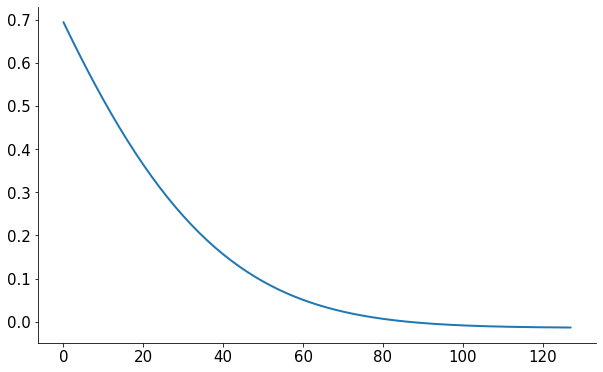

In [23]:
plt.plot(RH_1)

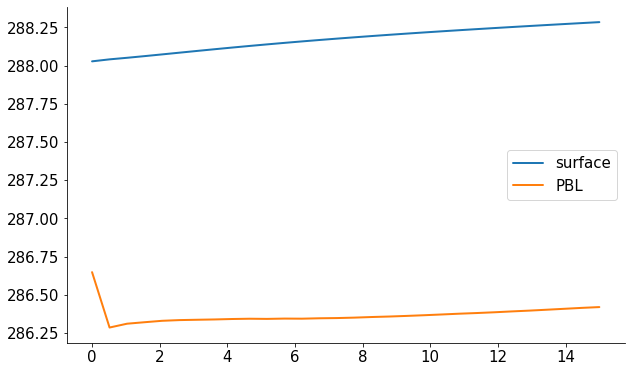

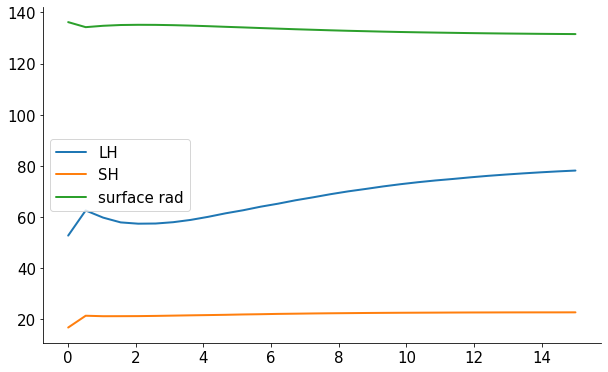

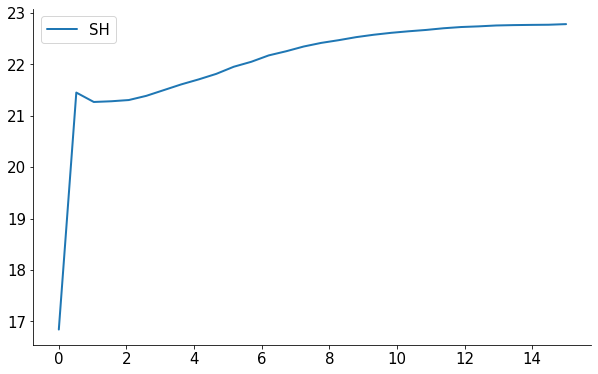

In [10]:
t = status/2
t = np.linspace(0,t,len(Ts_rec))
ini = 0
fin = len(Ts_rec)
plt.plot(t[ini:fin],Ts_rec[ini:fin],label = 'surface')
plt.plot(t[ini:fin],Tbl_rec[ini:fin],label = 'PBL')
plt.legend()
plt.show()
plt.plot(t[ini:fin],LH_rec[ini:fin],label = 'LH')
plt.plot(t[ini:fin],SH_rec[ini:fin],label = 'SH')
plt.plot(t[ini:fin],rads_rec[ini:fin],label = 'surface rad')
plt.legend()
plt.show()
plt.plot(t[ini:fin],SH_rec[ini:fin],label = 'SH')
plt.legend()
plt.show()

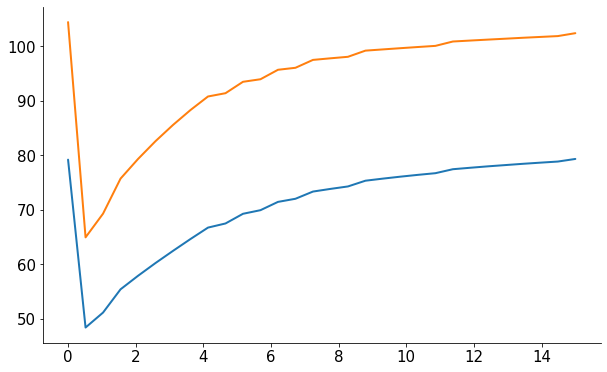

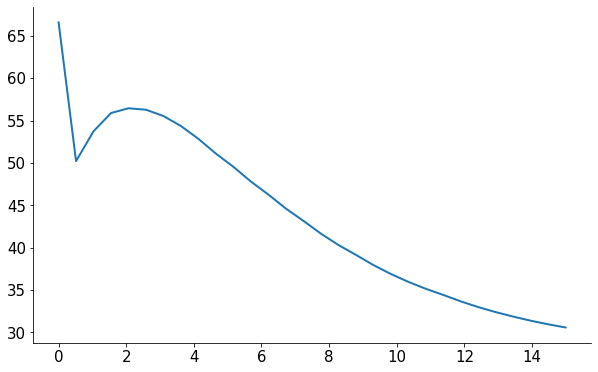

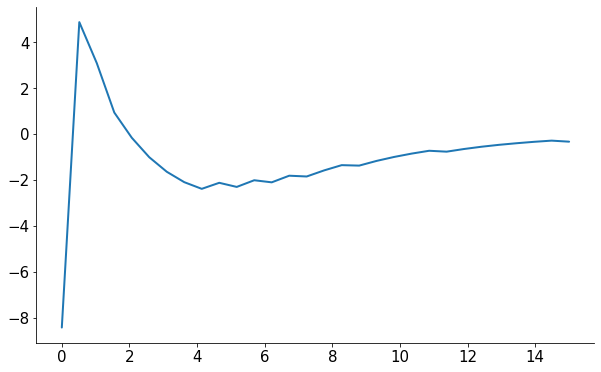

In [11]:
plt.plot(t[ini:fin],PH_rec[ini:fin],label = '-precipitation heating')
plt.plot(t[ini:fin],rada_rec[ini:fin],label = 'troposphere rad')
plt.show()

Esdif = []
for i in range(len(Ts_rec)):
    c = rads_rec[i]-(SH_rec[i]+LH_rec[i])
    Esdif.append(c)
plt.plot(t[ini:fin],Esdif[ini:fin])
plt.show()

Eadif = []
for i in range(len(Ts_rec)):
    c = -rada_rec[i]+(SH_rec[i]+PH_rec[i])
    Eadif.append(c)
plt.plot(t[ini:fin],Eadif[ini:fin])
plt.show()

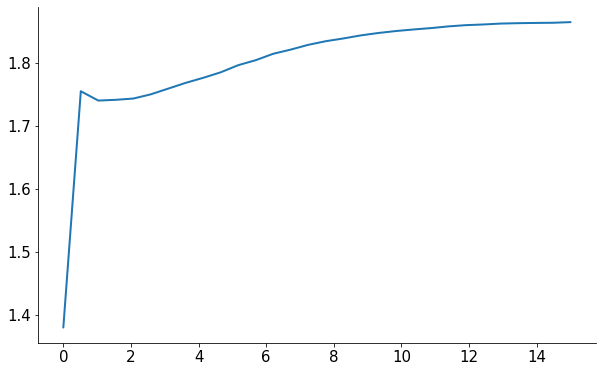

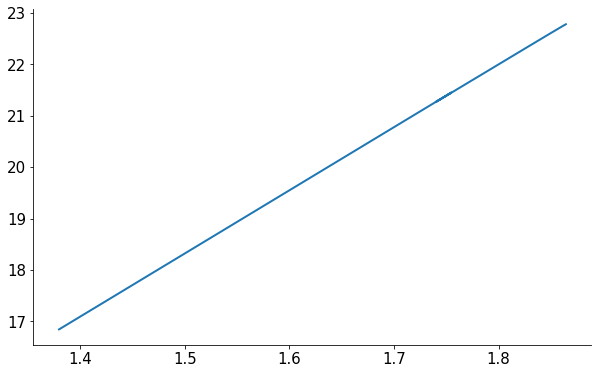

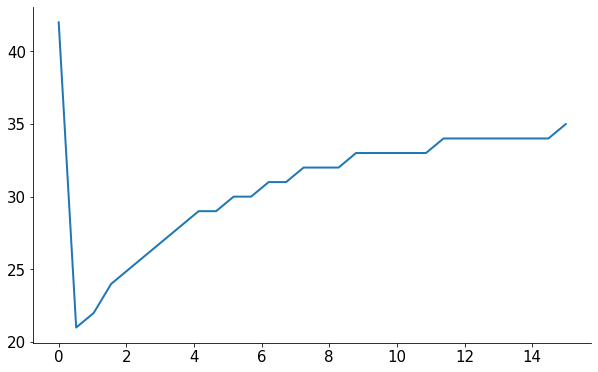

In [12]:
Tdif = []
for i in range(len(Ts_rec)):
    c = Ts_rec[i]-Tbl_rec[i]
    Tdif.append(c)
plt.plot(t[ini:fin],Tdif[ini:fin])
plt.show()
plt.plot(Tdif[ini:fin],SH_rec[ini:fin])
plt.show()
plt.plot(t[ini:fin],ctop_rec[ini:fin])

In [13]:
%%time
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=int(ndays)/5, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()


CPU times: user 307 ms, sys: 1.97 ms, total: 308 ms
Wall time: 306 ms


[0.77439736]
first with latent heat and precipitation, then without:
surface T 288.26371015061716 288.0095837548023
atmosphere PBL T 286.92833516039923 287.46757194811926
toa radiation [21.99779087] [62.86242564]
surface radiation 131.56111416646746 169.07991958884747
atmosphere radiative cooling [-109.5633233] -109.56332329838284 [-106.21749395]
sensible heat [22.78374787]
precipitation heat (J s-1 m-2) and mass (mm day-1) [-79.33419438] [-2.74069348] [-2.74069318]
latent heat evaporation (J s-1 m-2) and mass (mm day-1) 78.20686246826138 2.701748467516107
Column mass of water vapor (kg m-2) [17.13591532]


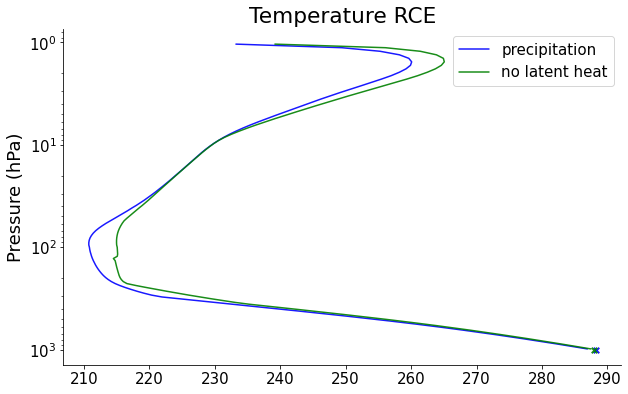

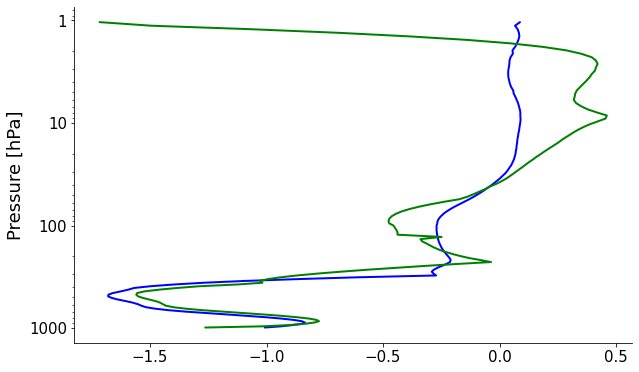

In [14]:
print(prec_eff)
print('first with latent heat and precipitation, then without:')
print('surface T',
      surface['temperature'][0],surface_rce['temperature'][0])
print('atmosphere PBL T',
      atmosphere['T'][0,0],atmosphere_rce['T'][0,0])
print('toa radiation',
      radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',
      radiation['toa']-net_rad_surface, atm_rad, rce.radiation['toa']-rad_surf_rce)
print('sensible heat',SH)
print('precipitation heat (J s-1 m-2) and mass (mm day-1)',
      prec_heating, prec_heating/Lv * seconds_day, prec_mass * 2)
print('latent heat evaporation (J s-1 m-2) and mass (mm day-1)', 
      LH, LH/Lv * seconds_day)
print('Column mass of water vapor (kg m-2)', M_w)


fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'precipitation')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'no latent heat')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue', label = 'precipitation')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'green', label = 'no latent heat')
plt.show()

In [15]:
print((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
print((165)
                               * seconds_day * timestep / surface.heat_capacity)

0.026495375180825297
0.0332297041761482


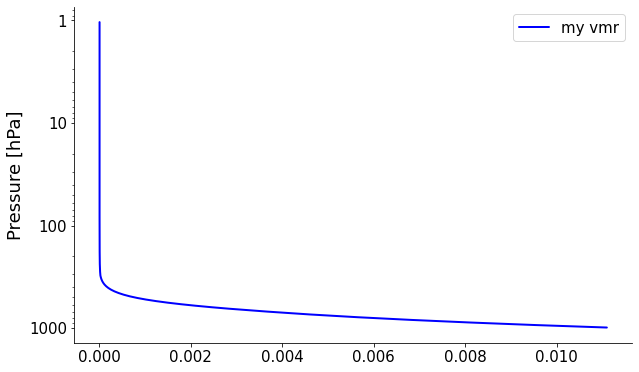

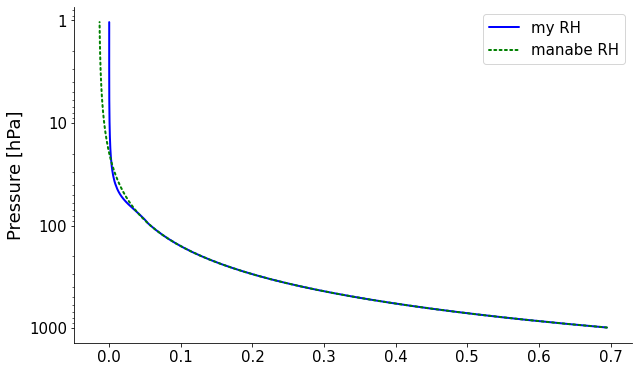

In [16]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my RH')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe RH', linestyle = 'dotted')
plt.legend()
plt.show()

In [17]:
print(atmosphere['phlev'][:4])

[100000.          97317.22068295  94666.49309856  92049.14849365]


In [18]:
print(atmosphere['plev'][:4])
print(np.gradient(atmosphere['plev'][:4]))

[98649.49096825 95982.70677655 93348.64798487 90748.60669154]
[-2666.7841917  -2650.42149169 -2617.05004251 -2600.04129333]


In [19]:
print(atmosphere['plev'][:conv_top])

[98649.49096825 95982.70677655 93348.64798487 90748.60669154
 88183.79685561 85655.35445494 83164.33780182 80711.72801105
 78298.42961472 75925.27131802 73593.00689003 71302.31618318
 69053.80627507 66848.01272581 64685.40094449 62566.3676576
 60491.24247274 58460.28953049 56473.7092376  54531.6400743
 52634.1604689  50781.29073271 48972.99504834 47209.18350463
 45489.71417153 43814.39520823 42182.98699838 40595.20430578
 39050.71844465 37549.15945857 36090.11830215 34673.14902021
 33297.77091887 31963.47072369 30669.70471994]


In [20]:
print(conv_top)

35


In [21]:
print(np.append(288,konrad.lapserate.get_moist_adiabat(atmosphere['plev'],288,T_min=0.)[:-1]))
print(moist_adiabat(atmosphere['plev'],288,T_radiation))

[288.         286.91074819 285.78699423 284.63358029 283.44984575
 282.23390657 280.98446936 279.70006424 278.37899188 277.01972439
 275.62031169 274.1788464  272.69315918 271.16005773 269.57587576
 267.93652599 266.23743183 264.47425117 262.64334642 260.74139119
 258.76601342 256.71590284 254.5908483  252.39254198 250.12382096
 247.78889956 245.39229446 242.93841961 240.43238005 237.87990387
 235.28683325 232.6587949  230.00153622 227.32001265 224.619082
 221.90279903 219.17483126 216.43811928 213.6954729  210.94897577
 208.20032362 205.45110856 202.70248984 199.95544397 197.21075109
 194.46899304 191.73056085 188.99605879 186.26562889 183.53939193
 180.81758685 178.10025596 175.38740907 172.67893938 169.97478832
 167.274698   164.57854957 161.88596847 159.19659858 156.50993667
 153.8255721  151.14278845 148.46090502 145.77909605 143.09644952
 140.41179114 137.72387156 135.0314547  132.33278691 129.62603772
 126.90916011 124.17974784 121.4349945  118.67176745 115.88643009
 113.0746413